# Курс: Введение в нейронный сети. Промежуточная аттестация

## Выполнено на датасете по Северстали:

* сегментация и обучение нейронной сети

In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import pandas as pd
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau

from keras.models import Model
from efficientnet.tfkeras import EfficientNetB1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROWS = 128
COLS = 128
SHAPE = (ROWS, COLS)
# DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Graduation/data/severstal/train_images'

In [ ]:
def rle_decode(mask_rle, shape: tuple = (256, 1600)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(data: pd.DataFrame, image_name: str, shape: tuple = (256, 1600)):
    encoded_masks = data.loc[data['ImageId'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1]), dtype=np.float32)
    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :] = mask
    return masks

In [ ]:
def show_images(image, mask, pred):
  if pred is not None:
    fig, ax = plt.subplots(1, 3, figsize=(8, 4))
    ax[2].imshow(pred)
  else:
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  ax[0].imshow(image)
  ax[1].imshow(mask)
  plt.show()

In [ ]:
images = []
classes = []
masks = []

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Graduation/data/train.csv')
for img, ClassId, EncodedPixels in tqdm(data.values):
    try:
      # image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Graduation/data/severstal/train_images/{}'.format(img), cv2.IMREAD_GRAYSCALE)
      image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Graduation/data/severstal/train_images/{}'.format(img))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, SHAPE)
      images.append(image)
      classes.append(ClassId)
      mask = make_mask(data, img)
      mask = cv2.resize(mask, SHAPE)
      masks.append(mask)
    except:
      continue

100%|██████████| 7095/7095 [00:08<00:00, 801.52it/s] 


In [ ]:
len(images), len(classes), len(masks)

(540, 540, 540)

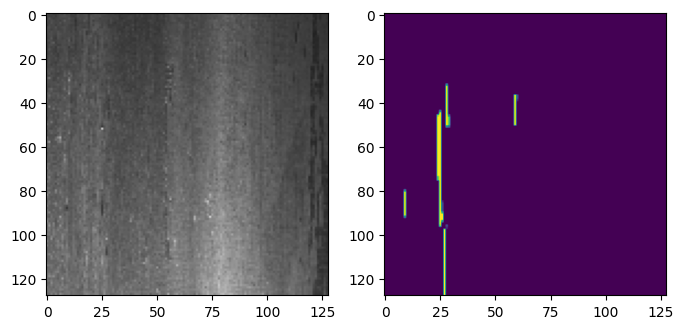

In [ ]:
show_images(images[0], masks[0], None)

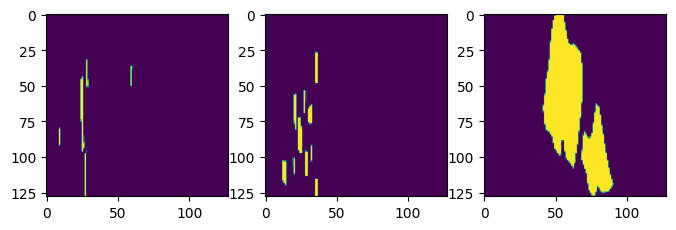

In [ ]:
show_images(masks[0], masks[1], masks[2])

In [ ]:
encoder = LabelEncoder()

In [ ]:
x = np.array(images)
# x = x / 255

c = encoder.fit_transform(classes)
c = to_categorical(c)

m = np.array(masks)

In [ ]:
x_train, x_test, c_train, c_test, m_train, m_test = train_test_split(
    x,
    c,
    m,
    test_size=0.2,
#    stratify=c,
    shuffle=True)

In [ ]:
print(x_train.shape, c_train.shape, m_train.shape)

(432, 128, 128, 3) (432, 4) (432, 128, 128)


In [ ]:
num_classes = 1
inputs = tf.keras.layers.Input((ROWS, COLS, 3))

In [ ]:
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

In [ ]:
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

In [ ]:
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

In [ ]:
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

In [ ]:
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [ ]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

In [ ]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

In [ ]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

In [ ]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

In [ ]:
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)

In [ ]:
seg_model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

In [ ]:
seg_history = seg_model.fit(x_train, m_train, epochs=45, batch_size=32, validation_data=(x_test, m_test), callbacks=[lrd])

Epoch 1/45
14/14 [==============================] - 21s 320ms/step - loss: 0.4842 - accuracy: 0.8668 - val_loss: 0.3504 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 2/45
14/14 [==============================] - 1s 73ms/step - loss: 0.3288 - accuracy: 0.9364 - val_loss: 0.3383 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 3/45
14/14 [==============================] - 1s 72ms/step - loss: 0.2642 - accuracy: 0.9433 - val_loss: 0.3336 - val_accuracy: 0.9240 - lr: 0.0010
Epoch 4/45
14/14 [==============================] - 1s 74ms/step - loss: 0.2297 - accuracy: 0.9457 - val_loss: 0.3004 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/45
14/14 [==============================] - 1s 76ms/step - loss: 0.2077 - accuracy: 0.9471 - val_loss: 0.2758 - val_accuracy: 0.9466 - lr: 0.0010
Epoch 6/45
14/14 [==============================] - 1s 78ms/step - loss: 0.1920 - accuracy: 0.9481 - val_loss: 0.2211 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 7/45
14/14 [==============================] - 1s 76ms/step - loss: 0

1/1 [==============================] - 0s 18ms/step


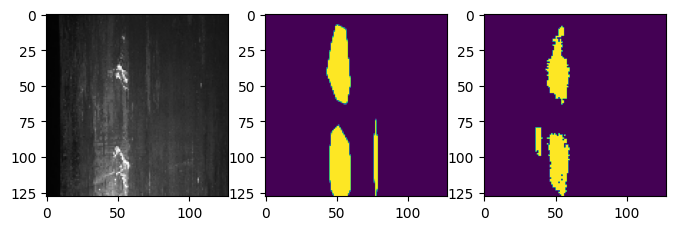

In [ ]:
index = random.randint(0, len(x_test))
test_image = x_test[index]
test_mask = m_test[index]
prediction = seg_model.predict(test_image[np.newaxis, ...])[0]
pred_mask = (prediction > 0.5).astype(np.uint8)
show_images(test_image, test_mask, pred_mask)